## Image classification with Convolutional Neural Networks

## My dataset: 'Old Polish Cars'

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import shutil as sh

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots_wcz import *

In [0]:
PATH = "data/old_polish_cars/old_polish_cars_v5_photos-split/"

In [0]:
sz=224
# sz=128

## Easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Exploration

In [0]:
!ls {PATH}

models	test1  tmp  train  valid


In [0]:
!ls {PATH}valid

Autobus Jelcz MZK     FSC Zuk	   FSO Warszawa  Fiat 126p Maluch  Syrena 105
Autobus Jelcz Ogorek  FSO Polonez  Fiat 125p	 Gazik		   ZSD Nysa


In [0]:
files = !ls {PATH}valid/"Fiat 126p Maluch" | head
files

['100_1487452822.24.jpg',
 '60_1487452789.18.jpg',
 '64_1487452793.54.jpg',
 '73_1487452802.96.jpg',
 '91_1487452816.32.jpg',
 'fp126p.1.000021.jpg',
 'fp126p.1.000022.jpg',
 'fp126p.1.000027.jpg',
 'fp126p.1.000065.jpg',
 'fp126p.1.000066.jpg']

In [0]:
files[9]

'fp126p.1.000066.jpg'

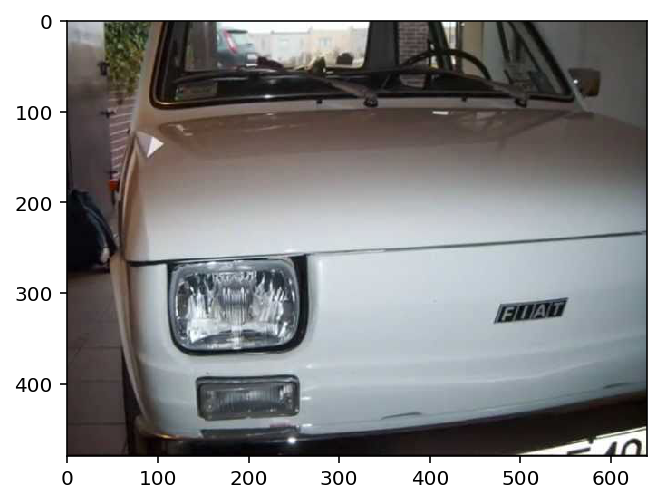

In [0]:
img = plt.imread(f'{PATH}valid/Fiat 126p Maluch/{files[9]}')
plt.imshow(img);

In [0]:
img.shape

(480, 640, 3)

In [0]:
img[50:51,150:152]

array([[[66, 62, 59],
        [66, 62, 59]]], dtype=uint8)

## Training

In [0]:
arch=resnet34
tfms = tfms_from_model(arch, sz)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 10)

A Jupyter Widget

[ 0.       0.7172   0.44433  0.84082]                         
[ 1.       0.50385  0.3609   0.87754]                         
[ 2.       0.40044  0.31594  0.89629]                         
[ 3.       0.36914  0.29097  0.89707]                         
[ 4.       0.31354  0.26834  0.9127 ]                         
[ 5.       0.30362  0.24871  0.91484]                         
[ 6.       0.27461  0.24033  0.91191]                         
[ 7.       0.24681  0.22947  0.9207 ]                         
[ 8.       0.23124  0.21058  0.92559]                         
[ 9.       0.22357  0.2067   0.93047]                         



## Predict on validation set

In [0]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(980, 10)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
print('preds: ', len(preds), preds[0:10], '\nprobs: ', len(probs), probs[0:20])

preds:  980 [0 0 0 0 0 0 1 0 0 0] 
probs:  980 [ 0.00736  0.00002  0.00001  0.00055  0.00001  0.01544  0.52949  0.00003  0.0154   0.       0.00002  0.00013
  0.00006  0.00005  0.00012  0.00334  0.00007  0.00001  0.00974  0.00005]


## Analyzing results

### Confusion matrix 

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)

[[96  1  0  0  0  0  0  0  0  1]
 [ 3 90  1  0  0  0  1  0  2  1]
 [ 0  0 97  0  0  0  0  0  0  1]
 [ 0  0  0 85  0  5  6  1  1  0]
 [ 0  0  0  0 95  0  0  0  3  0]
 [ 0  0  0  6  3 79  7  1  2  0]
 [ 0  0  0  4  2  1 89  2  0  0]
 [ 0  0  0  0  0  0  0 98  0  0]
 [ 0  0  0  0  7  1  1  0 89  0]
 [ 0  0  2  0  0  1  2  0  0 93]]


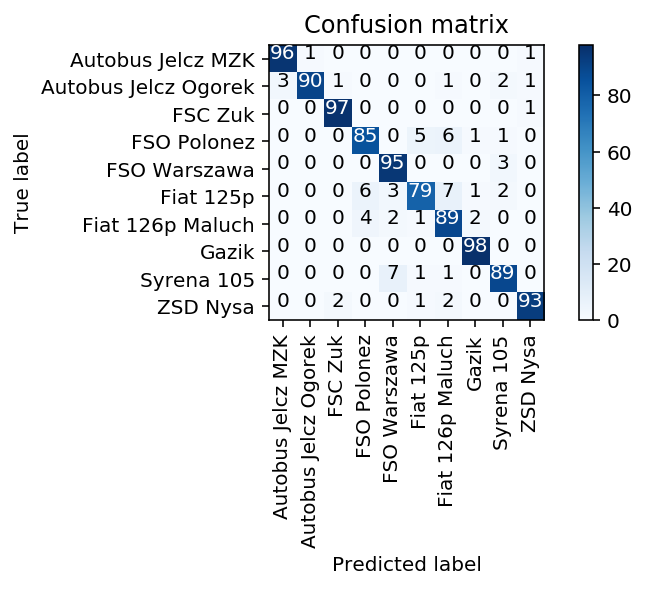

In [0]:
plot_confusion_matrix(cm, data.classes)

## Inference

In [0]:
# + code one file inference
# * code list of files inference

In [0]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

def inference(image_path):
    # fname is Path()
    ds = FilesIndexArrayDataset([image_path.name], np.array([0]), val_tfms, image_path.parent)
    dl = DataLoader(ds)
    learn.precompute = False
    preds = learn.predict_dl(dl)[0]
    probs = np.exp(preds)
    pred = np.argmax(preds)
    class_name = data.classes[pred]
    prob = probs[pred]
    return pred, class_name, prob

In [0]:
PATH2 = Path(f'{PATH}test1')
print(PATH2)
file_paths = sorted(PATH2.glob('*.jpg'))

for file_path in file_paths[0:10]:
    (pred, class_name, prob) = inference(file_path)
    print('%s\t%s\t%s\t%s' % (pred, class_name, prob, file_path.name))

In [0]:
def inference_array(image_paths):
    ds = FilesIndexArrayDataset([x.name for x in image_paths], np.zeros([len(image_paths)]), val_tfms, image_paths[0].parent)
    dl = DataLoader(ds)
    learn.precompute = False
    log_preds = learn.predict_dl(dl)
    probs = np.exp(log_preds)
    pred_class_ids = np.argmax(log_preds, axis=1)
    class_names = [data.classes[x] for x in pred_class_ids]
    # rslts = [(image_paths[x], pred_class_ids[x], class_names[x], np.max(probs[x,:])) for x in range(len(log_preds))]
    
    rslts = []
    
    for x in range(len(log_preds)):
        rslt = {
                'image_path': image_paths[x],
                'class_idx': pred_class_ids[x],
                'class_name': class_names[x],
                'prob': np.max(probs[x,:])
                }
        rslts.append(rslt)

    return rslts

In [0]:
PATH2 = Path(f'{PATH}test1')
print(PATH2)
image_paths = sorted(PATH2.glob('*.jpg'))
print(len(image_paths))
image_paths_short = image_paths[0:125]
print(len(image_paths_short))
rslts = inference_array(image_paths_short)
print(len(rslts))
print(rslts[0])

In [0]:
rslts

## Checking categories

In [0]:
cat = 'Autobus Jelcz Ogorek'
cat_path = Path('data/old_polish_cars/old_polish_cars_v4_photos') / cat
image_paths = sorted(cat_path.glob('*.jpg'))
print(len(image_paths))
image_paths_short = image_paths#[0:225]
print(len(image_paths_short))
rslts = inference_array(image_paths_short)


bad_path = Path('data/old_polish_cars/bad2')
bad_cat_path = bad_path / cat
os.makedirs(bad_cat_path, exist_ok=True)

incorrect_count = 0
for rslt in rslts:
    correct = rslt['class_name'] == cat
    if not correct:
        incorrect_count = incorrect_count + 1
        image_path = rslt['image_path']
        dest_path = bad_cat_path / image_path.name
        print(image_path)
        print(dest_path)
        # sh.move(image_path, dest_path)
        
print(incorrect_count, len(image_paths_short), (len(image_paths_short) - incorrect_count) / len(image_paths_short))

In [0]:
def check_category(cat_path, dataset_path, bad_path):
    cat_path = dataset_path / cat
    image_paths = sorted(cat_path.glob('*.jpg'))
    print('image_paths: ', len(image_paths))
    rslts = inference_array(image_paths)
    bad_cat_path = bad_path / cat_path.name
    os.makedirs(bad_cat_path, exist_ok=True)

    incorrect_count = 0
    incorrect_results = []
    for idx, rslt in enumerate(rslts):
        correct = rslt['class_name'] == cat
        if not correct:
            incorrect_count = incorrect_count + 1
            image_path = rslt['image_path']
            dest_path = bad_cat_path / image_path.name
            print(idx, image_path.name, ',', rslt['class_name'])
            incorrect_results.append(rslt)
            sh.move(image_path, dest_path)
        
    print(incorrect_count, len(image_paths_short), (len(image_paths_short) - incorrect_count) / len(image_paths_short))
    return incorrect_results

In [0]:
cat = 'Fiat 126p Maluch'
dataset_path = Path('data/old_polish_cars/old_polish_cars_v4_photos_cleaned2')
bad_path = Path('data/old_polish_cars/bad2')
rslts = check_category(cat, dataset_path, bad_path)

In [0]:
dataset_path = Path('data/old_polish_cars/old_polish_cars_v4_photos_cleaned2')
bad_path = Path('data/old_polish_cars/bad3')

for cat in data.classes:
    print(cat)
    rslts = check_category(cat, dataset_path, bad_path)

## Analyzing results: looking at pictures

In [0]:
# This is the label for a val data
len(data.val_y)

In [0]:
data.val_y[0:200]

In [0]:
img=data.val_ds.get_x(200)
img.shape

In [0]:
plt.imshow(img);

In [0]:
data.classes[data.val_ds.get_y(200)]

In [0]:
data.val_dl.dataset.get_x      

In [0]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

In [0]:
np.exp(log_preds[:2])

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [str(probs[x]) + " " + Path(data.val_ds.fnames[x]).stem for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [0]:
rand_by_correct(False)

In [0]:
len(data.val_ds.fnames)

In [0]:
data.val_ds.fnames[100]

In [0]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [0]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [0]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])

In [0]:
for class_idx, class_name in enumerate(data.classes):
    plot_val_with_title(most_by_correct(class_idx, True), 'Most correct "' + data.classes[class_idx] + '"')

In [0]:
plot_val_with_title(most_by_correct(1, True), "Most correct 1")

In [0]:
plot_val_with_title(most_by_correct(2, True), "Most correct 2")

In [0]:
plot_val_with_title(most_by_correct(3, True), "Most correct 3")

In [0]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect 0")

In [0]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect 1")

In [0]:
plot_val_with_title(most_by_correct(2, False), "Most incorrect 2")

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [0]:
lrf=learn.lr_find()

In [0]:
learn.sched.plot_lr()

In [0]:
learn.sched.plot()

## Analyzing results

for three classes
* accuracy 0.91027
* 424
* (136+104+145)/424

In [0]:
(136+104+145)/424

for 10 classes, 4 epochs
* accuracy: 0.8282
* val size: 997

## Improving our model

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

In [0]:
plots(ims, rows=2)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [0]:
learn.fit(1e-2, 20)

In [0]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
print('preds: ', len(preds), preds[0:20], '\nprobs: ', len(probs), probs[0:20])

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)

In [0]:
plot_confusion_matrix(cm, data.classes)

In [0]:
bad_predicted_fnames = []
bad_predicted_idxs = []
bad_predicted_classes = []
# plot table of train or val preds
# idx, image name, correct category, actual category
for idx in range(len(preds)):
    correct_class_idx = data.val_y[idx]
    predicted_class_idx = preds[idx]
    fname = data.val_ds.fnames[idx]
    predicted_class = data.classes[predicted_class_idx]
    if correct_class_idx != predicted_class_idx:
        bad_predicted_fnames.append(fname)
        bad_predicted_idxs.append(idx)
        bad_predicted_classes.append(predicted_class)
        # print(idx, correct_class_idx, predicted_class_idx, probs[idx], data.val_ds.fnames[idx], ',', data.classes[predicted_class_idx])
        print('%s\t%s\t%s\t%s\t%s\t%s' % (idx, correct_class_idx, predicted_class_idx, probs[idx], fname, predicted_class))

In [0]:
#plot bad images
# bad_predicted_idxs
plot_val_with_title(bad_predicted_idxs[0:3], "")

In [0]:
# copy bad predicted images:
for idx, fname in enumerate(bad_predicted_fnames):
    img_path = PATH + fname
    # print(img_path)
    fname = bad_predicted_classes[idx] + ', ' + Path(fname).name
    dest_path = Path(PATH) / "bad_predicted_images" / fname
    print(dest_path)
    sh.copy2(img_path, dest_path)